# Customer Churn Prediction


## Introduction
The aim of this assignment is to build a statistical model which will accurately predict when an insurance company is about to lose their customer. There are sixteen anonymised features in the dataset and one response variable (named 'labels') which indicates churn (1) or no churn (0) for each observation. Two datasets are provided for training (trainSet.csv) and testing (testSet.csv) the models.

Data Source: https://www.kaggle.com/mukulsingh/insurance-churn-prediction

Section 1: Exploratory data analsis is completed in this section. The data is characterised with single variable exploration, then relationships are explored through correlation and graphical analysis. Findings are discussed along the way and summarised at the end. 

Section 2: Models which are strong candidates for effective statistical learning given the data discoveries we have made are discussed. The code and development process for two classificaltion model varieties as well as any data transformations required to run them are included, such as one hot encoding and standard scaling of features.

Section 3: The final model(s) results are presented and interpreted at the end. Performance metrics are discussed and key features that are strongly associated with the response variable are identified and discussed.

Load the required libraries:

In [2]:
library(psych)
library(ggplot2)
#library(GGally) 
library(ggplot2)
library(reshape2)
#library(corrgram)
#library(corrplot)
library(OneR)
library(RColorBrewer)

Read in the test and train datasets that were provided.

In [3]:
# load test dataset
test <- read.csv(file = 'testSet.csv')

# load train dataset
train <-  read.csv(file = 'trainSet.csv')

#### Our general approach to Exploratory Data Analysis (EDA):

What are we doing? What is the goal? How will we predict churn?
1. Explore individual variables, their characteristics such as spread, variance, distribution etc.
2. Identify important features which have a relationship with our label, and how they interact.
3. Explore the qualities of the relationships to identify which models will give strongest results, and how we can transform the data to aid with learning.
4. Identify features with no relationship and exclude them from our models, for improved efficiency and reduced over fitting.
5. Identify features which strongly correlate with one another, to eliminate duplicate information. 
6. Build effective models which are supported by our exploration.

# Exploratory Data Analysis

First look at the data

In [4]:
# show the first rows
head(train)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,labels
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1.5127910,-0.2434605,0.1434182,2.01858846,0.07622994,-0.4114531,-0.2519404,1,1,1,0,1,0,0,0,3,0
2,-1.5007763,-0.2125875,1.2248391,-0.15984112,-0.56935064,-0.4114531,-0.2519404,8,2,1,0,0,0,0,8,3,0
3,0.9477471,0.5812426,-0.3372133,0.77987360,-0.56935064,-0.4114531,-0.2519404,0,2,1,0,0,0,2,8,3,0
4,-0.8415585,-0.2217837,0.5038918,-0.37729577,0.39902023,-0.4114531,-0.2519404,9,1,1,0,0,0,0,1,3,0
5,-0.5590365,-0.5922597,-1.1783185,-0.41612696,-0.56935064,-0.4114531,-0.2519404,1,2,1,0,1,0,0,8,3,0
6,0.9477471,-0.4654833,-0.5775291,0.08867847,-0.24656035,2.2551433,2.3528870,4,2,2,1,1,0,0,8,0,0


Check the data types.

In [5]:
# show training the data structure
str(train)

'data.frame':	27126 obs. of  17 variables:
 $ feature_0 : num  1.513 -1.501 0.948 -0.842 -0.559 ...
 $ feature_1 : num  -0.243 -0.213 0.581 -0.222 -0.592 ...
 $ feature_2 : num  0.143 1.225 -0.337 0.504 -1.178 ...
 $ feature_3 : num  2.019 -0.16 0.78 -0.377 -0.416 ...
 $ feature_4 : num  0.0762 -0.5694 -0.5694 0.399 -0.5694 ...
 $ feature_5 : num  -0.411 -0.411 -0.411 -0.411 -0.411 ...
 $ feature_6 : num  -0.252 -0.252 -0.252 -0.252 -0.252 ...
 $ feature_7 : int  1 8 0 9 1 4 7 6 6 9 ...
 $ feature_8 : int  1 2 2 1 2 2 1 1 1 1 ...
 $ feature_9 : int  1 1 1 1 1 2 1 2 1 3 ...
 $ feature_10: int  0 0 0 0 0 1 0 0 0 0 ...
 $ feature_11: int  1 0 0 0 1 1 0 1 1 1 ...
 $ feature_12: int  0 0 0 0 0 0 0 1 1 0 ...
 $ feature_13: int  0 0 2 0 0 0 0 2 0 0 ...
 $ feature_14: int  0 8 8 1 8 8 1 6 5 9 ...
 $ feature_15: int  3 3 3 3 3 0 3 3 3 3 ...
 $ labels    : int  0 0 0 0 0 0 0 0 0 0 ...


Our response variable 'labels' is a factor variable.

In [6]:
#change label data type to factor
train$labels <- as.factor(train$labels)

#change the test dataset to match
test$labels <- as.factor(test$labels)

We want to be certain that the two test and train datasets are compatible with one another. Do they have the same data types? The same features in each?

In [7]:
# Show the testing data structure 
str(test)

'data.frame':	6782 obs. of  17 variables:
 $ feature_0 : num  -1.03 -0.842 -1.501 -0.277 -0.936 ...
 $ feature_1 : num  -0.222 -0.356 -0.265 -0.402 -0.268 ...
 $ feature_2 : num  0.504 -1.539 -1.419 1.826 1.585 ...
 $ feature_3 : num  -0.9054 -0.1055 0.3993 -0.8976 0.0537 ...
 $ feature_4 : num  0.0762 2.9813 -0.5694 6.2092 -0.5694 ...
 $ feature_5 : num  -0.411 -0.411 -0.411 -0.411 -0.411 ...
 $ feature_6 : num  -0.252 -0.252 -0.252 -0.252 -0.252 ...
 $ feature_7 : int  0 0 7 0 0 7 5 9 4 1 ...
 $ feature_8 : int  1 1 2 1 2 2 1 1 1 1 ...
 $ feature_9 : int  1 1 1 1 1 1 1 1 2 1 ...
 $ feature_10: int  0 0 0 0 0 0 0 0 0 0 ...
 $ feature_11: int  1 1 1 1 1 1 0 1 1 1 ...
 $ feature_12: int  0 0 1 0 0 1 0 0 0 1 ...
 $ feature_13: int  2 2 2 0 0 2 0 2 0 2 ...
 $ feature_14: int  6 6 6 5 4 8 1 8 3 8 ...
 $ feature_15: int  3 3 3 3 3 3 3 3 3 3 ...
 $ labels    : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...


Show the number of unique values in each feature and the labels.

In [8]:
apply(train,2,function(x) length(unique(x)))

feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  feature_6 
        77       5901         31       1403         46        499         35 
 feature_7  feature_8  feature_9 feature_10 feature_11 feature_12 feature_13 
        12          3          4          2          2          2          3 
feature_14 feature_15     labels 
        12          4          2

We are satisfied that features 0-6 are numeric type and 7-15 are integer in both test and train sets. We also know the numeric variables are continuous while the integer ones are discrete. It's possible that the integer variables are a mix of both ordinal and nominal values, but we don't have information about which belong in either category. Some qualitative data may have no order to their numeric assignment. One hot encoding might need to be concidered later, we really don't know enough about the data for now though.

What proportion of the data is test versus train?

In [9]:
# get the dimentions of each dataset and return the proportion of data in the training dataset
dim(test)[1] / (dim(test)[1] + dim(train)[1])

[1] 0.2000118

The test dataset makes up one fifth of our total data

## Single Variable Exploration

How is the response variable distributed? Is it imbalanced? Is it biased?

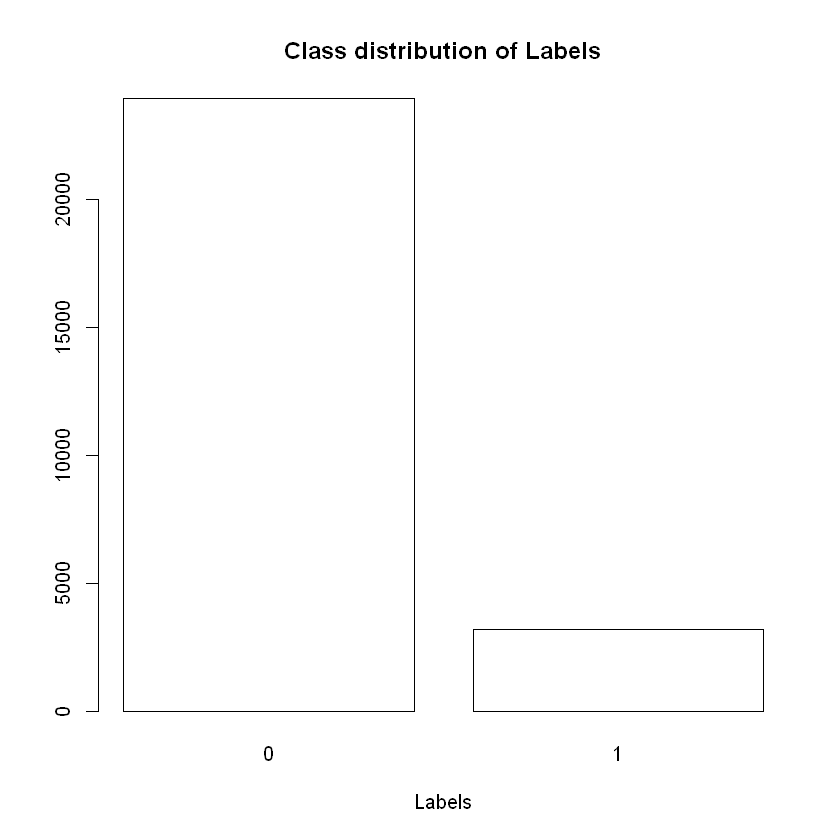

In [10]:
# produce a bar chart showing how many observations in our label data have their class equal to 1 or 0.
barplot(table(train$labels), xlab = "Labels", main = "Class distribution of Labels", col = "white")

There is no **detectable** bias in the label data, as we do not know any true information about real churn rates compared to the rates observed in this dataset. However, the class distribution in the label is very imbalanced (regardless of bias), this will likely become an issue for many learning algorithms later.



Descriptive statistics for continuous data:

Descriptive statistics for qualitative data: ??

More detailed summary statistics

In [11]:
# return summary statistics for the train dataset
round(describe(train), 3)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
feature_0,1,27126,-0.005,1.000,-0.182,-0.068,0.977,-2.160,5.091,7.251,0.677,0.292,0.006
feature_1,2,27126,0.001,0.986,-0.297,-0.193,0.223,-3.081,26.223,29.304,7.503,103.612,0.006
feature_2,3,27126,0.004,1.000,0.023,-0.010,1.247,-1.779,1.826,3.605,0.088,-1.058,0.006
feature_3,4,27126,-0.002,0.997,-0.307,-0.186,0.530,-1.002,18.095,19.097,3.157,18.827,0.006
feature_4,5,27126,0.000,1.009,-0.247,-0.210,0.479,-0.569,19.444,20.013,5.101,44.119,0.006
feature_5,6,27126,-0.003,0.997,-0.411,-0.285,0.000,-0.411,8.128,8.539,2.639,7.088,0.006
feature_6,7,27126,-0.009,0.795,-0.252,-0.197,0.000,-0.252,23.626,23.878,7.360,96.290,0.005
feature_7,8,27126,4.336,3.273,4.000,4.242,4.448,0.000,11.000,11.000,0.268,-1.265,0.020
feature_8,9,27126,1.170,0.605,1.000,1.213,0.000,0.000,2.000,2.000,-0.098,-0.423,0.004


Some initital findings from summary statistics:
- **Missing Data:** There is no missing data in any features
- **Mean:** The data all appear to have relatively similar means, ranging between values of -1 and 6
- **Median:** The range of median values is slightly wider than the mean, but not by much.
- **Standard Deviation:** 7 & 14 have the highest standard deviation. The lowest variance features include 10 and 12, we expect these may contribute the least to our prediction outcomes.
- **Range:** The range of values in all the data only spread from (approximately) -2 to 24. Feature 1 has the widest range of all, next to 3, 4 and 6.
- **Skew:** Feature 1 , 6 and 10 have highest skew, in the positive direction. Negative skewed variables are minimally affected.
- **Range:** Features 1 & 6 have the widest range
- **Distributions:** Features 10, 11 and 12 are integer and have a range of 1, making them binomial (as well as label), we'll know more about other variables later
- **Kurtosis:** Features 1, 4, 6 and 10 have relatively high kurtosis, making their tails very short. Conversely, quite a few variables have longer tails, measuring no lesser than -2 though
- **Scaling:** there has been no feature scaling yet (e.g. min-max scaling), we may need to do this for some types of statistical model
- **Expected Data Characteristics:** Given that we don't have any particular knowledge about each feature, we cannot comment on the expected or unexpected characteristics of each variable. Only that our response variable has two classes, 0 and 1 which represent churn and no churn as expected.

Histograms and Density Plots for our continuous data:

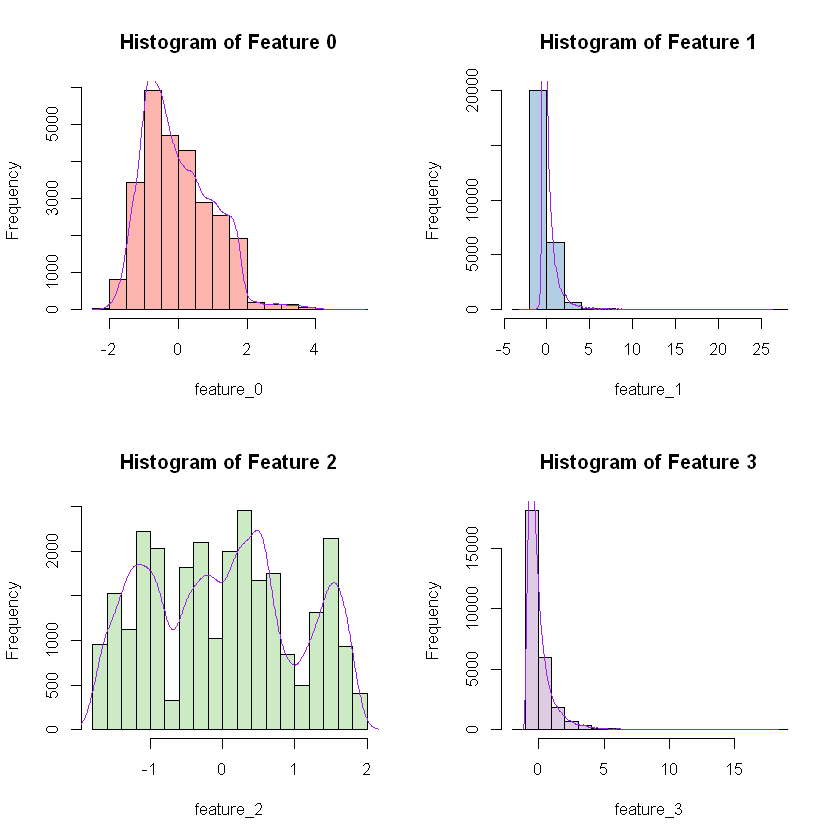

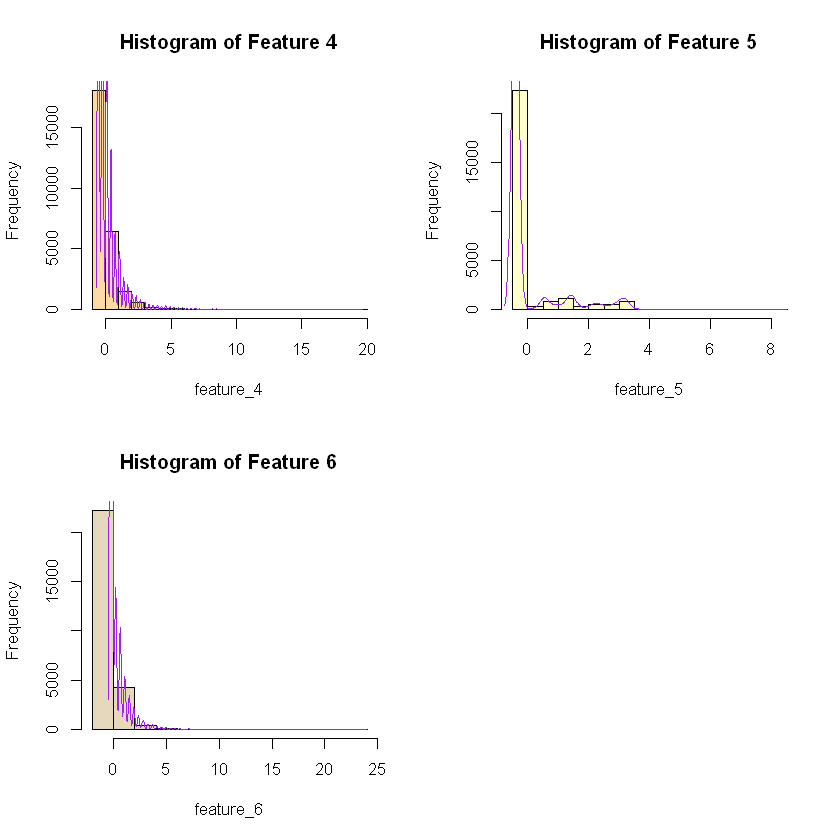

In [53]:
#increase scale size of jupyter plots for some very detailed ones momentarily.
options(jupyter.plot_scale=1) 

# Histogram for features 0 to 6
par(mfrow = c(2,2))
for (i in 1:7 ) {
    h <- hist(train[,i], plot=FALSE)
    plot(h, main=paste("Histogram of Feature", i-1), xlab = names(train[i]), col = brewer.pal(8, name = "Pastel1")[i])
    d <- density(train[,i])
    lines(x = d$x, y = d$y * length(train[,i]) * diff(h$breaks)[1], col = "purple", lwd = 1.5)
}

## With desity line scale help from https://stackoverflow.com/questions/13960896/add-density-lines-to-histogram-and-cumulative-histogram

The histograms would tell us that the data here is a mix of left skewed (0), exponential (1, 3, 4 & 6) and uniformly (2?) distributed features are seen here. But the density plots say a whole lot more. Most of our exponential data is just very highly right skewed unimodal. Our uniform feature (2) could be multimodal.  There are also some interesting artefacts on features 4 & 6, some kind of decaying harmonic oscillation. Feature 5 appears to have some kind of normal distribution with a rigth tail, could be right skewed unimodel, or it could be something else, it might help to take a closer look at the tail end of the data using a logarithmic scale.

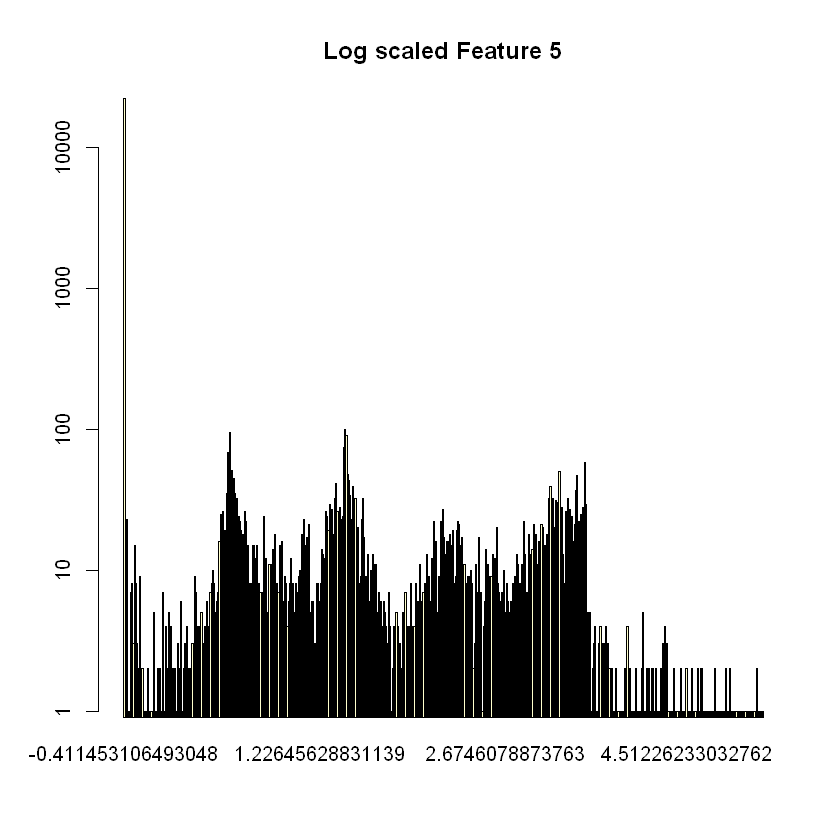

In [61]:
#increase scale size of jupyter plots for some very detailed ones momentarily.
options(jupyter.plot_scale=2) 
#par(mfrow = c(1,2))

barplot(table(train[,6]), log="y", xlab = names(train[,6]), main = paste("Log scaled Feature", 5), col = brewer.pal(8, name = "Pastel1")[6])

This is definately not the best chart option for the job, but it does have an inbuilt log scale. It shows that the data could be multimodal.

It could be improved with binning:

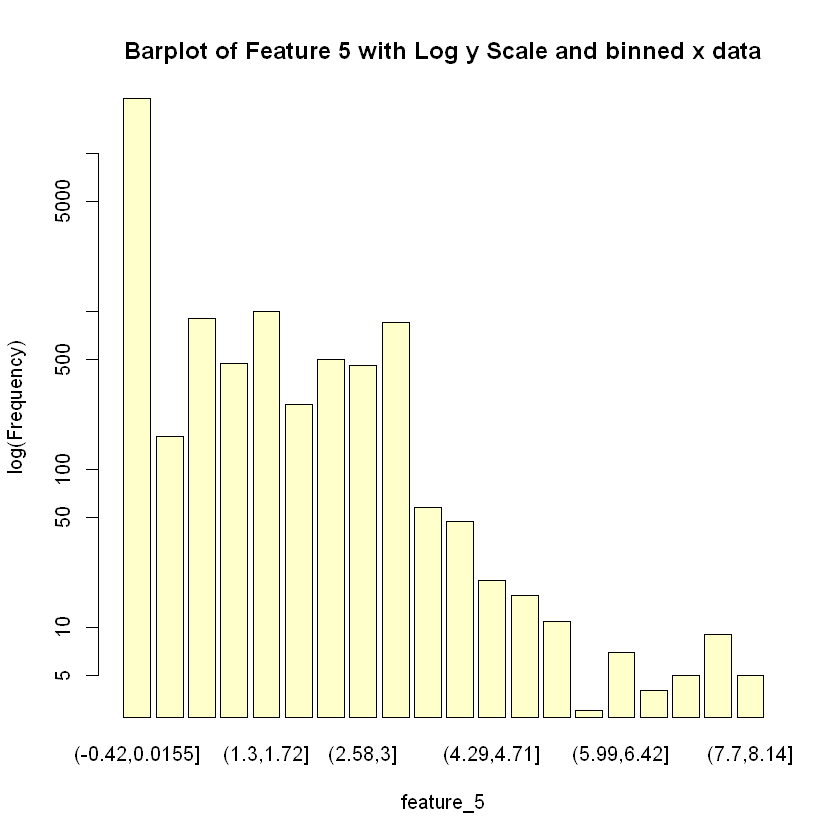

In [60]:
barplot(table(bin(train[,6], nbins = 20)), log = "y", xlab = "feature_5", ylab = "log(Frequency)", main = "Barplot of Feature 5 with Log y Scale and binned x data", col = brewer.pal(8, name = "Pastel1")[6])

What to say about this?

Bar chart exploration for our discrete data:

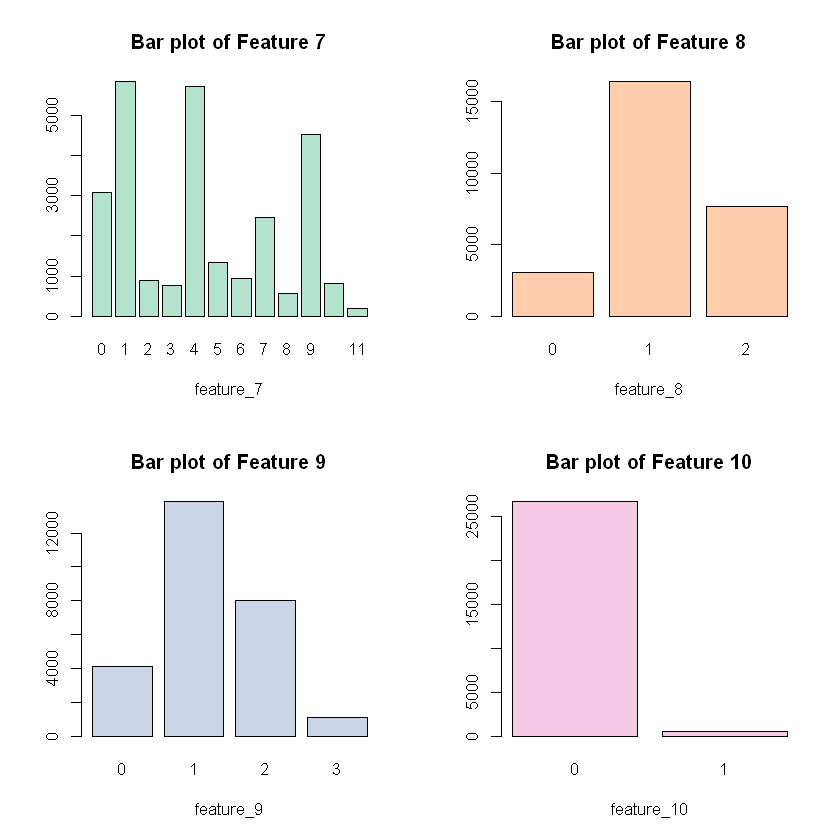

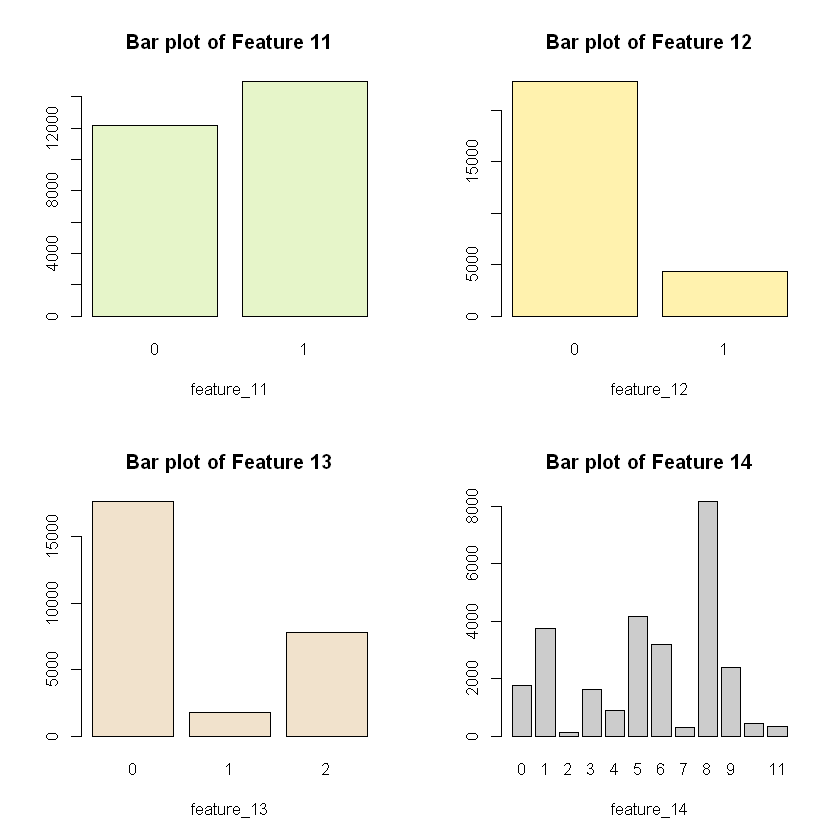

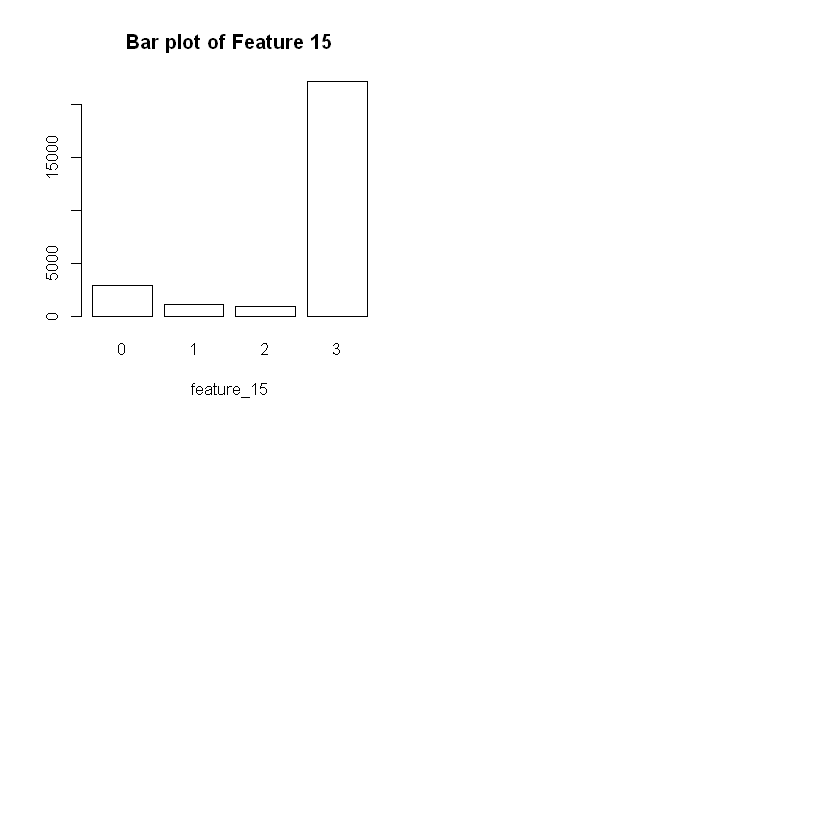

In [63]:
#increase scale size of jupyter plots for some very detailed ones momentarily.
options(jupyter.plot_scale=1)


# Bar chart for features 7 to 15
par(mfrow = c(2,2))
for (i in 8:16 ) {
        barplot(table(train[,i]), xlab = names(train[i]), main = paste("Bar plot of Feature", i-1), col = brewer.pal(8, name = "Pastel2")[i-7])
}

# Not Sure if we need the box plots?

Box plots of numeric and integer vars seperated for easier readability.

Continuous variables:

No id variables; using all as measure variables

Warning message:
"Removed 13712 rows containing non-finite values (stat_boxplot)."


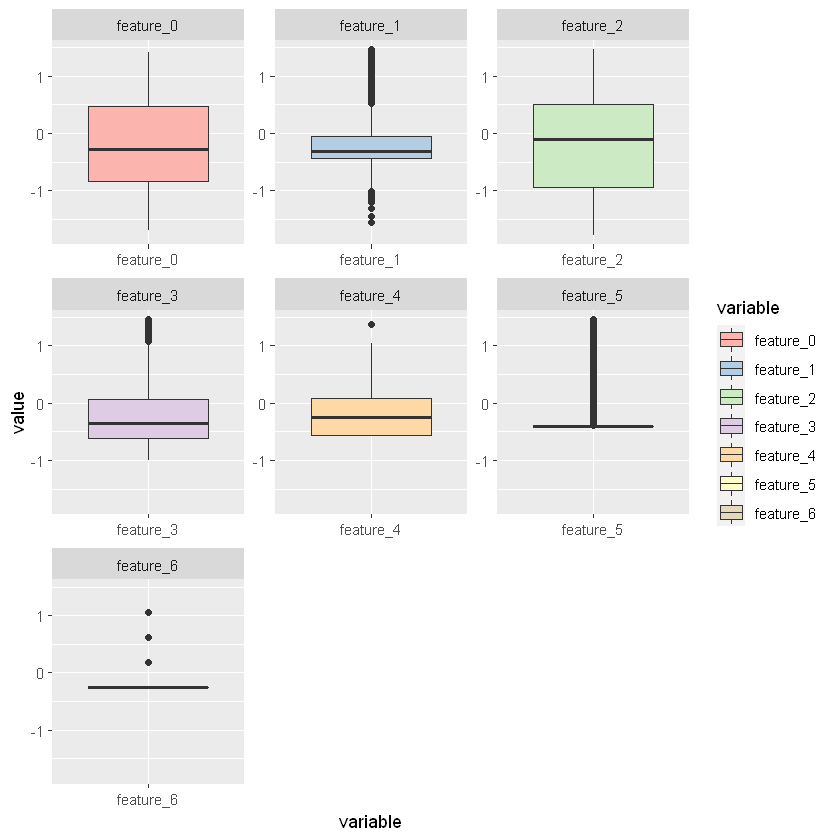

In [64]:
#boxplot(train[1:7], las=2, cex.axis = 1, col = "orange")

#reshape the data for ggplot
train_melt_cont <- melt(as.data.frame(train[,c(1,2,3,4,5,6,7)]))

#create boxplots
ggplot(train_melt_cont,aes(x = variable, y = value, fill = variable)) +
facet_wrap(~variable, scales="free")+
scale_y_continuous(limits = c(quantile(train[,3], c(0, 0.9))[1], quantile(train[,3], c(0, 0.9))[2]))+
geom_boxplot()+
scale_fill_brewer(palette="Pastel1")

Discrete variables:

Using labels as id variables

Warning message in RColorBrewer::brewer.pal(n, pal):
"n too large, allowed maximum for palette Pastel2 is 8
Returning the palette you asked for with that many colors
"


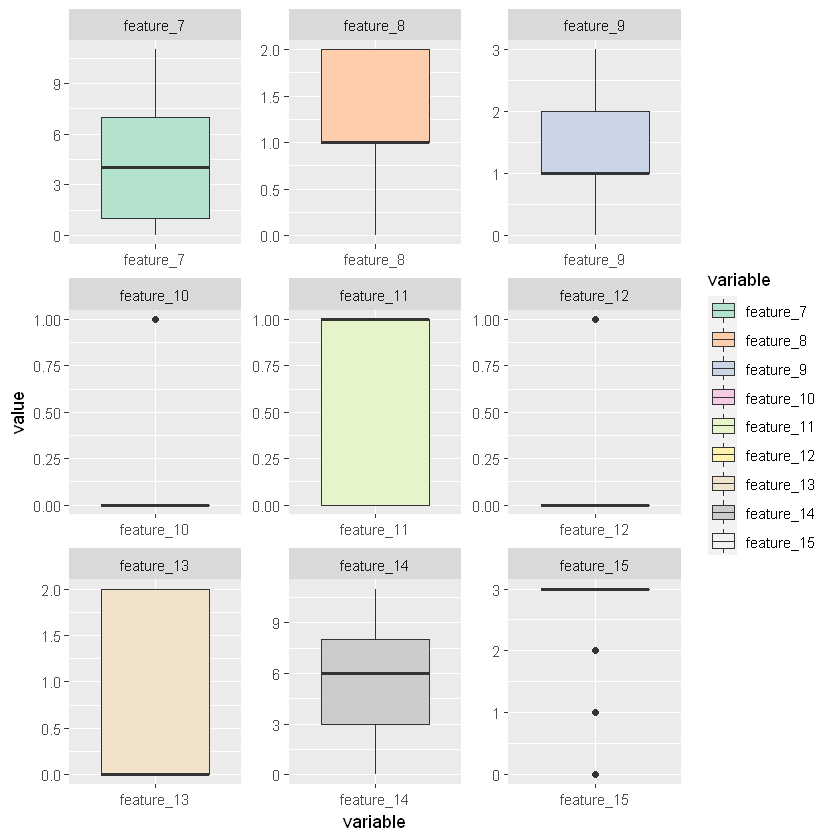

In [65]:
#boxplot(train[8:17], las=2, cex.axis = 1,col = "orange")

#reshape the data for ggplot
train_melt_cat <- melt(as.data.frame(train[,c(8:17)]))

# create boxplots
ggplot(train_melt_cat,aes(x = variable, y = value, fill = variable)) +
facet_wrap(~variable, scales="free")+
geom_boxplot()+
scale_fill_brewer(palette="Pastel2")

Earlier we found features 10,11 and 12 along with the labels all have two possible discrete values. It appears all but feature 11 are primarliy distributed at zero with less than a quarter of the data at one. Feature 11 on the otherhand is a little more evenly distributed with one quartile of the data distributed at zero and the remainder at one.

## Summary of single variable exploration:

### Quantitative vs Qualitative Variables:
As we suspected from the summary statistics, we can see that features 0 - 6 are continuous while 7 to 15 are discrete. As we have no context for this data, we cannot deduce easily whether the discrete variables are ordinal (logically ordered or ranked) or nominal (have no logical sequence). It is possible that their relationships with other variables could reveal the possibility of a rank or logical order, but we can never know for certain. This information is important to determine whether one hot encoding is needed for specific learning algorithms.

### Distributions:
Other notable observations incluide that feature 0 is skewed to the left while  it appears that 1, 3, 4 & 6 are all exponential (although increasing the bins might yet reveal they are all very highly skewed instead). Feature 5 looks interesting, it could be skewed, exponential or something else entirely. Meanwhile feature 2 is fairly uniformly distributed (possibly 7 and 11 too). Many of the integer features (7 and above) show a clear imbalance where one class is prefenced (particularly 10, 12 and 15). Features 8 and 9 could be somewhat normally distributed (the discretness of this data does not clearly show skew, there are too few possible values). It's hard to determine what information 7 & 14 have to give from this, they are discrete with no clear distribution meaning that they could be nominal variables with no clear rank or order, these would be prime candidates for tree methods or one hot encoding for other learning methods.

### Labels class imbalance
The response variable is not evenly distributed. The majority class (0) is very dominant here and so we expect that learning algorithms will significantly favour this class for positive prediction. Resampling may be necessary so as not to introduce bias in our learning/modelling algorithms.

### Other notes
Feature scaling has not been completed on this dataset. Some algorithms might need us to preform this.No missing data in any features. Given that we don't have any particular knowledge about each feature, we cannot comment more generally on the expected or unexpected characteristics of each variable, such as the range of values and outliers.
_________________________

# Two Variables Exploration

Checking for highly colinear features.

In [66]:
#increase scale size of jupyter plots for some very detailed ones momentarily.
options(jupyter.plot_scale=1) 

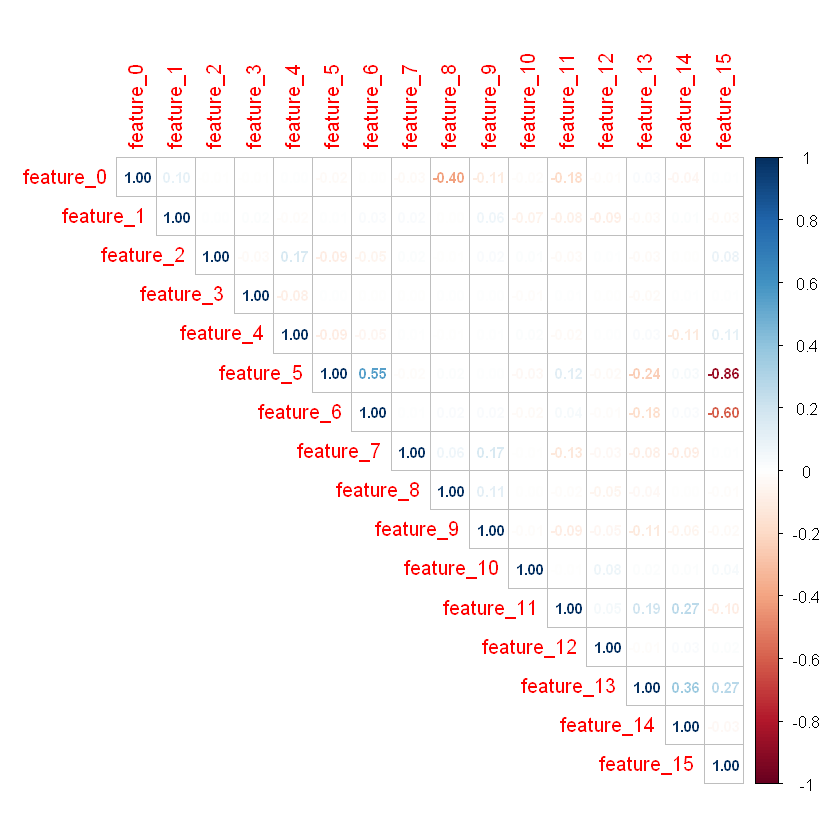

In [69]:
library(corrplot)

cor <- cor(train[-17])
corrplot(cor, method = 'number', type = 'upper',number.cex=0.75)

Feature 15 and 5 are highly correlated, 15 and 6 are somewhat similar too, it's possible these pairs carry the same information. We should remove feature 15 or 5 & 6. 

Feature correlation with the label:

Both ultimately don't correlate highly with our labels anyway. Infact, correlation with our label is all round pretty weak, feature 3 is giving it's best shot but it seems the relationships in this data are generally not linear.

### Comparing continuous variables with a categoric variable

Side by side box plots are ideal for comparing the continuous variables against categories in the response variable (labels). Many outliers have been deliberately removed with boxplots rescaled, as it was difficult to see the main quantiles of the distributions.

Warning message:
"package 'gridExtra' was built under R version 3.6.3"
Warning message:
"Removed 4955 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 2705 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 2602 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 2691 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 1314 rows containing non-finite values (stat_boxplot)."


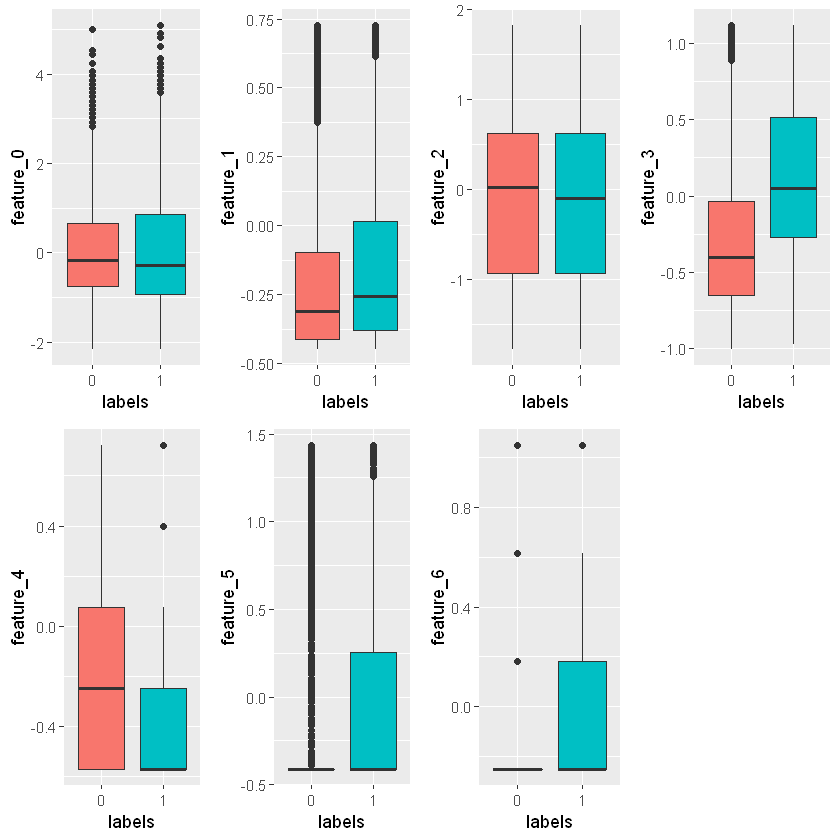

In [70]:
library(gridExtra) 
p1 <- ggplot(train, aes(x=factor(labels), y=train[,1], fill=factor(labels))) + 
          geom_boxplot()+
          #scale_y_continuous(limits = c(quantile(train[,1], c(0.1, 0.9))[1], quantile(train[,1], c(0.1, 0.9))[2]))+
          labs(x = "labels",y = names(train)[1]) +
          guides(fill="none")

p2 <- ggplot(train, aes(x=factor(labels), y=train[,2], fill=factor(labels))) + 
          geom_boxplot()+
          scale_y_continuous(limits = c(quantile(train[,2],c(0.1, 0.9))[1], quantile(train[,2], c(0.1, 0.9))[2]))+
          labs(x = "labels",y = names(train)[2]) +
          guides(fill="none")

p3 <- ggplot(train, aes(x=factor(labels), y=train[,3], fill=factor(labels))) + 
          geom_boxplot()+
          #scale_y_continuous(limits = c(quantile(train[,3], c(0.1, 0.9))[1], quantile(train[,3], c(0.1, 0.9))[2]))+
          labs(x = "labels",y = names(train)[3]) +
          guides(fill="none")

p4 <- ggplot(train, aes(x=factor(labels), y=train[,4], fill=factor(labels))) + 
          geom_boxplot()+
          scale_y_continuous(limits = c(quantile(train[,4], c(0, 0.9))[1], quantile(train[,4], c(0, 0.9))[2]))+
          labs(x = "labels",y = names(train)[4]) +
          guides(fill="none")

p5 <- ggplot(train, aes(x=factor(labels), y=train[,5], fill=factor(labels))) + 
          geom_boxplot()+
          scale_y_continuous(limits = c(quantile(train[,5], c(0, 0.9))[1], quantile(train[,5], c(0, 0.9))[2]))+
          labs(x = "labels",y = names(train)[5]) +
          guides(fill="none")

p6 <- ggplot(train, aes(x=factor(labels), y=train[,6], fill=factor(labels))) + 
          geom_boxplot()+
          scale_y_continuous(limits = c(quantile(train[,6], c(0.1, 0.9))[1], quantile(train[,6], c(0.1, 0.9))[2]))+
          labs(x = "labels",y = names(train)[6]) +
          guides(fill="none")

p7 <- ggplot(train, aes(x=factor(labels), y=train[,7], fill=factor(labels))) + 
          geom_boxplot()+
          scale_y_continuous(limits = c(quantile(train[,7], c(0, 0.95))[1], quantile(train[,7], c(0, 0.95))[2]))+
          labs(x = "labels",y = names(train)[7]) +
          guides(fill="none")


grid.arrange(p1, p2, p3, p4, p5, p6, p7, ncol = 4)

These box plots reveal that features 1, 3, 4, 5 and 6 have the greatest difference in distribution for classes in our response variable, in comparison features 0 and 2 appear more similar, although there are still some differences seen there too. We'll revisit these distributions in greater detail later.

Warning message:
"Removed 619 rows containing non-finite values (stat_density)."
Warning message:
"Removed 726 rows containing non-finite values (stat_density)."
Warning message:
"Removed 111 rows containing non-finite values (stat_density)."
Warning message:
"Removed 447 rows containing non-finite values (stat_density)."


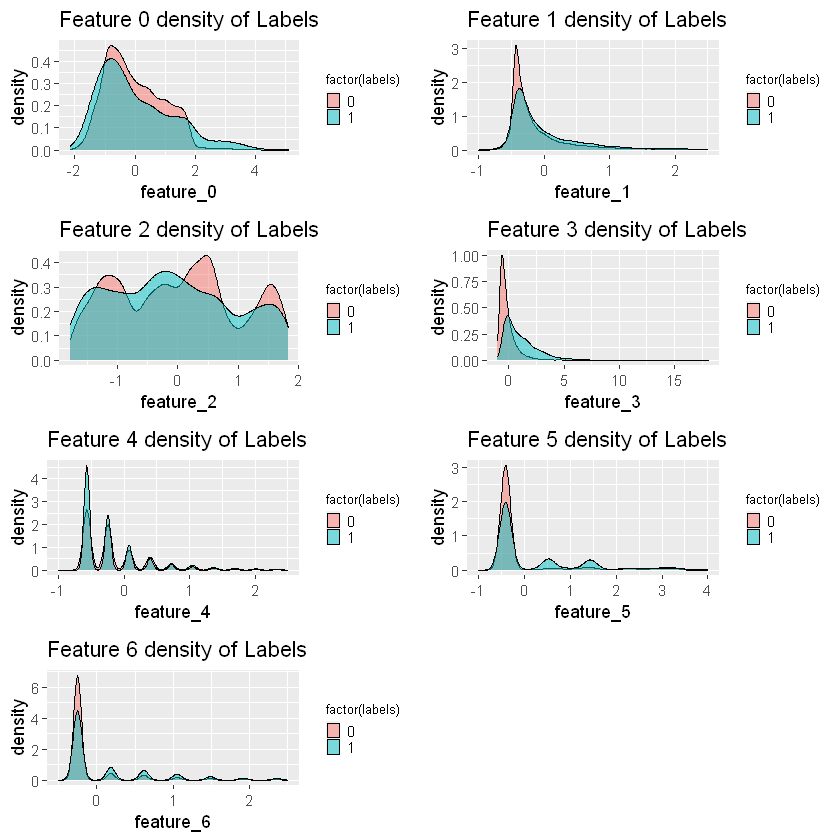

In [82]:
p1 <- ggplot(train) +
  geom_density(aes(x = feature_0, fill = factor(labels)), alpha=.5) +
  labs(x = 'feature_0') +
  ggtitle("Feature 0 density of Labels")+
  theme(legend.key.size = unit(0.3, 'cm'), legend.title = element_text(size=8))

p2 <- ggplot(train) +
  geom_density(aes(x = feature_1, fill = factor(labels)), alpha=.5) +
  labs(x = 'feature_1') +
  ggtitle("Feature 1 density of Labels")+
  theme(legend.key.size = unit(0.3, 'cm'), legend.title = element_text(size=8)) +
  xlim(c(-1,2.5))

p3 <- ggplot(train) +
  geom_density(aes(x = feature_2, fill = factor(labels)), alpha=.5) +
  labs(x = 'feature_2') +
  ggtitle("Feature 2 density of Labels")+
  theme(legend.key.size = unit(0.3, 'cm'), legend.title = element_text(size=8))

p4 <- ggplot(train) +
  geom_density(aes(x = feature_3, fill = factor(labels)), alpha=.5) +
  labs(x = 'feature_3') +
  ggtitle("Feature 3 density of Labels")+
  theme(legend.key.size = unit(0.3, 'cm'), legend.title = element_text(size=8))

p5 <- ggplot(train) +
  geom_density(aes(x = feature_4, fill = factor(labels)), alpha=.5) +
  labs(x = 'feature_4') +
  ggtitle("Feature 4 density of Labels")+
  theme(legend.key.size = unit(0.3, 'cm'), legend.title = element_text(size=8)) +
  xlim(c(-1,2.5))

p6 <- ggplot(train) +
  geom_density(aes(x = feature_5, fill = factor(labels)), alpha=.5) +
  labs(x = 'feature_5') +
  ggtitle("Feature 5 density of Labels")+
  theme(legend.key.size = unit(0.3, 'cm'), legend.title = element_text(size=8)) +
  xlim(c(-1,4))

p7 <- ggplot(train) +
  geom_density(aes(x = feature_6, fill = factor(labels)), alpha=.5) +
  labs(x = 'feature_6') +
  ggtitle("Feature 6 density of Labels")+
  theme(legend.key.size = unit(0.3, 'cm'), legend.title = element_text(size=8)) +
  xlim(c(-0.5,2.5))

grid.arrange(p1, p2, p3, p4, p5, p6, p7, ncol = 2)

What to say about the density plots?

### Comparing two categoric variables
This is done well with segmented bar plots and mosaic plots. We'll use these to compare features 7-15 against our labels.

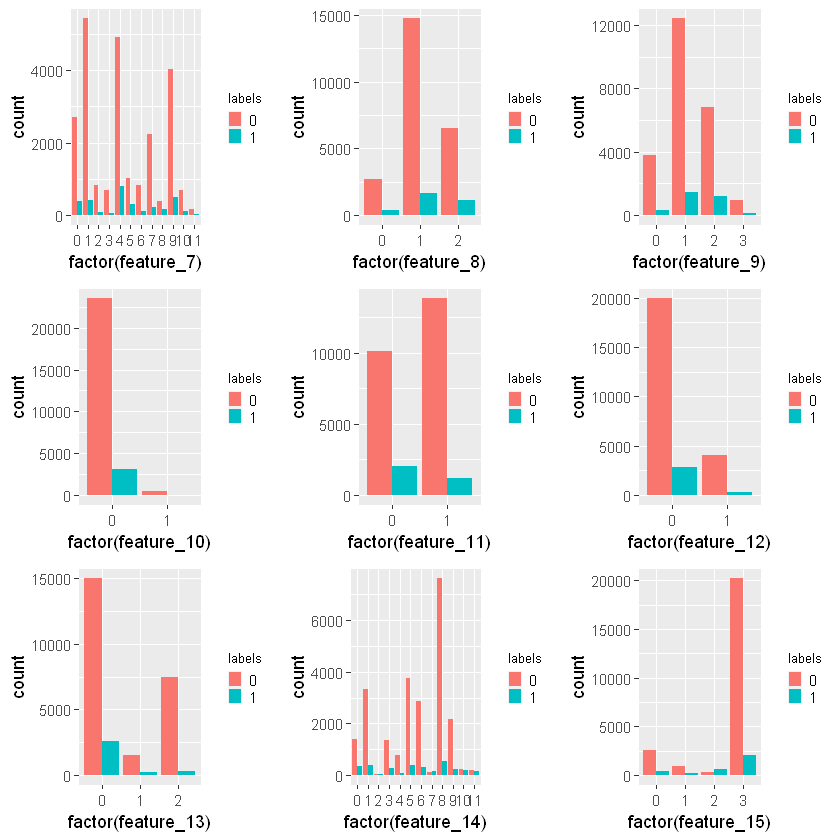

In [97]:
p7<- ggplot(train, aes(x = factor(feature_7), fill = labels)) + 
  geom_bar(position = "dodge") +
  theme(legend.key.size = unit(0.3, 'cm'), legend.title = element_text(size=8))

p8<- ggplot(train, aes(x = factor(feature_8), fill = labels)) + 
  geom_bar(position = "dodge") +
  theme(legend.key.size = unit(0.3, 'cm'), legend.title = element_text(size=8))

p9<- ggplot(train, aes(x = factor(feature_9), fill = labels)) + 
  geom_bar(position = "dodge") +
  theme(legend.key.size = unit(0.3, 'cm'), legend.title = element_text(size=8))

p10<- ggplot(train, aes(x = factor(feature_10), fill = labels)) + 
  geom_bar(position = "dodge") +
  theme(legend.key.size = unit(0.3, 'cm'), legend.title = element_text(size=8))

p11<- ggplot(train, aes(x = factor(feature_11), fill = labels)) + 
  geom_bar(position = "dodge") +
  theme(legend.key.size = unit(0.3, 'cm'), legend.title = element_text(size=8))

p12<- ggplot(train, aes(x = factor(feature_12), fill = labels)) + 
  geom_bar(position = "dodge") +
  theme(legend.key.size = unit(0.3, 'cm'), legend.title = element_text(size=8))

p13<- ggplot(train, aes(x = factor(feature_13), fill = labels)) + 
  geom_bar(position = "dodge") +
  theme(legend.key.size = unit(0.3, 'cm'), legend.title = element_text(size=8))

p14<- ggplot(train, aes(x = factor(feature_14), fill = labels)) + 
  geom_bar(position = "dodge") +
  theme(legend.key.size = unit(0.3, 'cm'), legend.title = element_text(size=8))

p15<- ggplot(train, aes(x = factor(feature_15), fill = labels)) + 
  geom_bar(position = "dodge") +
  theme(legend.key.size = unit(0.3, 'cm'), legend.title = element_text(size=8))


grid.arrange(p7, p8, p9, p10, p11, p12, p13, p14, p15, ncol = 3)

All of these bar charts show significant differences between the churn and no churn categories. This indicates that dependancies likely exist between our feature and labels which can be exploited with our statistical models in all of these cases.

Analysing labels seperately to find differences:

In [99]:
#increase scale size of jupyter plots for some very detailed ones momentarily.
options(jupyter.plot_scale=1.5) 

In [100]:
pairs(train[train$labels==1,-17], upper.panel = panel.cor, main = "Label = 1")

ERROR: Error in pairs.default(train[train$labels == 1, -17], upper.panel = panel.cor, : object 'panel.cor' not found


In [ ]:
pairs(train[train$labels==0,-17], upper.panel = panel.cor, main = "Label = 0")

There appears to be no major differences in correlation between any features and the two label values. This indicates that regression may not perform well with this data.

# Best predictors:
- 7 & 14 have the highest standard deviation, making them possibly strong predictors.
- Box plots indicate that there is label dependancy in most features. 0 has a wider distribution in class 1 than 0, distributions in feature 1 are offset from one another, there is an even wider offset in feature 3. Features 4...while 5 and 6 have the same mean but longer tails on label 1 relative to 0.
- Density plots tells us that...
- segmented bar plots tell us...


# Worst Predictors:
- 10 and 12 have low variance, which will likely make them poor predictors.
- Box plots indicate that feature 2 has the least dependancy on label class. 
- Density plots tells us that...
- segmented bar plots tell us...

# Overall variables of significance and insignificance
- ?

### Model selection and justification
Clearly explained how the models were developed with sufficient supporting information derived from exploratory data analysis and proper statistical diagnostics.

The exploratory analysis and diagnostics logically lead to the development of the models (including attribute/feature selection).

# Modelling

### Model quality comparison
Critically assess the accuracy of the models with in-depth statistical analysis. 

The comparison is logical and solid with an appropriate level of details. 

Demonstrates a high-level of understanding of the differences (i.e., advantages and disadvantages) between the models in regard to the task.

# Summary
Explanation of why the chosen subset of attributes have a significant impact on the prediction of the response variable.
- The subset of attributes leading to the prediction are identified and clearly justified with in-depth statistical analysis.
- The description and accompanying interpretation are comprehensible and convincing, in line with the findings from the model development.

The quality of the Jupiter notebook/ the R Markdown file, quality and readability of the R implementation.
- The Jupyter  Notebook is well structured in a logical order that clearly supports the development of the answers.
- The R code is logically structured and easy to read.
- Concise but precise code comments clearly explain how the code is intended to work.
- The redundant or unnecessary code is excluded from the final submission.


# Questions:
- The Week 2 tutorial explores the relationship between many variables with one another. Are we interested in just the relationships that we wish to predict? Why would we explore other relationships aside from just looking for duplicated information?
- Check for duplicates still?


# Concerns to follow up before modelling
- Resample data to even out label class
- Are categoric data ordinal? Should they be one hot encoded? Specifically look at 7, 8, 9, 13, 14, 15.
- Feature scaling might be needed for some models
- 

# Suggestions
If there is time:
- Convert legends to say Churn / No churn rather than 0/1
- set labels to factor type
- plot pairs to highlight potentially non-linear relationships between variables. The nagain, scatter plots are for numeric & numeric comparison. So only features 0 - 6 should be done.


# Rejection Zone...probably don't need this code but not 100% sure yet.

In [ ]:
# One stop shop, crashes everything...
library(GGally)
ggpairs(train, aes(color = labels)) + theme_bw()

The correlation between each feature and the labels.

I don't think we should use this....

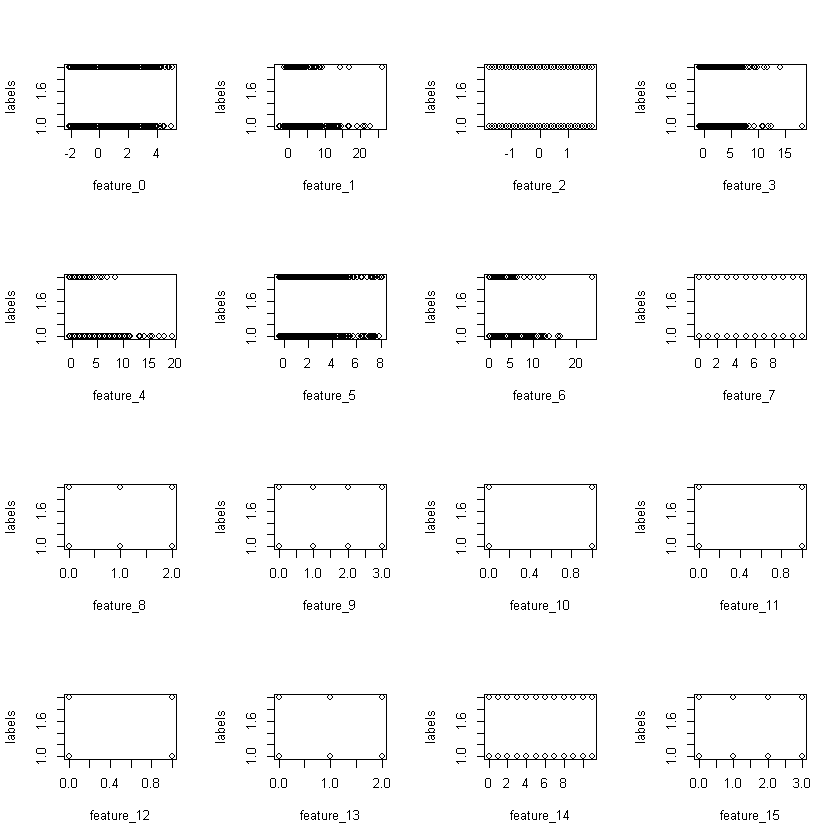

In [73]:
par(mfrow = c(4,4))
for (i in 1:(length(train) - 1)) {
        plot(train[,i], train$labels, ylab = 'labels', xlab = names(train)[i])
}

There appear to be differences in the distribution of data for each label correlated with features 1, 4 and 6. It is questionable whether this is also the case for 1, 3 and 5. These features should be explored further using geom_density filled by label to distinguish...

Correlation measurements are for the most part relatively low, the top 5 include:
1. -0.855 between features 5 & 15
2. -0.596	between features 15 & 6
3. 0.547	between features  5 & 6
4. -0.405	between features 8 and 0
5. 0.390	between the labels and 3

Remember this only measures the linear relationship between two variables. Visualising with all with a scatter plot could bring other non linear relationship patterns to the surface. These are a bit crowded with so many features though, so we will focus on the top 5 we've highlighted for now.

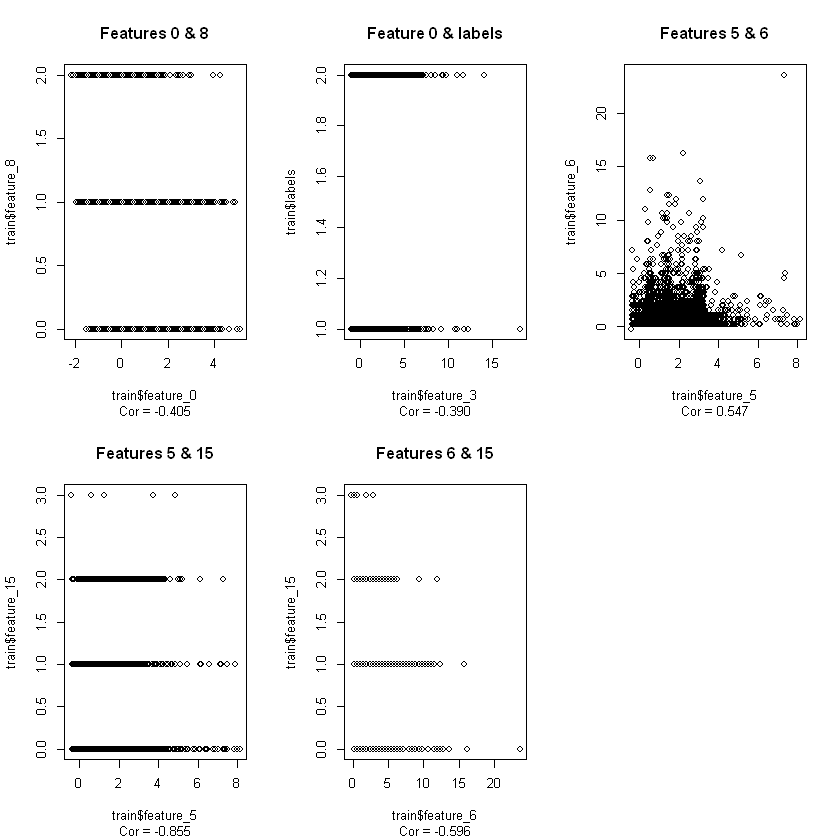

In [74]:
par(mfrow = c(2,3))
plot(train$feature_0, train$feature_8, main = "Features 0 & 8", sub = "Cor = -0.405")
plot(train$feature_3, train$labels, main = "Feature 0 & labels", sub = "Cor = -0.390")
plot(train$feature_5, train$feature_6, main = "Features 5 & 6", sub = "Cor = 0.547")
plot(train$feature_5, train$feature_15, main = "Features 5 & 15", sub = "Cor = -0.855")
plot(train$feature_6, train$feature_15, main = "Features 6 & 15", sub = "Cor = -0.596")

We can't really comment on whether we expected these correlations, we just know they're the most significant linear relationships we have found.